# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more. Use the hourly data instead of the daily data, add more layers, whatever you feel like.



In [220]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [221]:
rides = pd.read_csv('Bike-Sharing-Dataset/day.csv')

In [222]:
rides.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Dummy variables
Here we have a few categorical variables like season and weather. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [255]:
dummy_fields = ['season', 'weathersit']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=True)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,season_2,season_3,season_4,weathersit_2,weathersit_3,season_2,season_3,season_4,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.805833,0.160446,331,654,985,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0.363478,0.696087,0.248539,131,670,801,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0.196364,0.437273,0.248309,120,1229,1349,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0.200000,0.590435,0.160296,108,1454,1562,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0.226957,0.436957,0.186900,82,1518,1600,0,0,0,0,0,0,0,0,0,0


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [226]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 30 days of the data to use as a validation set after we've trained the network. We'll use this set to make predictions and compare them with the actual targets.

In [228]:
# Save the last 30 days 
validation = data[-30:]
data = data[:-30]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
val_features, val_targets = validation.drop(target_fields, axis=1), validation[target_fields]

We'll split the data into two sets, one for training and one for testing as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [229]:
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
test_features, test_targets = features.drop(split), targets.drop(split)

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. . You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x) = x$. The hidden layer will use the sigmoid function for activations.

**TODO:** Would be good to include a diagram of the network here probably. I'll add it if I have time.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method, including calculating the output error.
3. Implement the forward pass in the `run` method.
4. For an extra challenge, delete the backwards pass and implement the backpropagation algorithm yourself.
  

In [256]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [249]:
class NeuralNetwork:
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Set number of nodes in input, hidden and output layers.
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # Initialize weights
        # Weights from input to hidden layer
        self.wih = np.random.normal(0.0, self.hnodes**-0.5, 
                                       (self.hnodes, self.inodes))
        
        # Weights from hidden to output layer
        self.who = np.random.normal(0.0, self.onodes**-0.5, 
                                       (self.onodes, self.hnodes))
        self.lr = learningrate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = sigmoid
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = final_inputs
        
        # Output error
        output_errors = targets - final_outputs
        
        ### Backward pass ###
        # Backpropagated error
        hidden_errors = np.dot(self.who.T, output_errors)
        hidden_grad = hidden_outputs * (1.0 - hidden_outputs)
        
        # Update the weights
        self.who += self.lr * np.dot(output_errors, hidden_outputs.T)
        self.wih += self.lr * np.dot(hidden_errors * hidden_grad, inputs.T)
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [250]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the test set. This is called overfitting. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance.

In [262]:
### Set the hyperparameters here ###
epochs = 1001
learning_rate = 0.001
hidden_nodes = 50

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, 1, learning_rate)

losses = {'train':[], 'test':[]}
for e in range(epochs):
    # Go through all records in the training data set
    for record, target in zip(train_features.values, train_targets['cnt']):
        network.train(record, target)
    
    # Calculate losses for the training and test sets
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    test_loss = MSE(network.run(test_features), test_targets['cnt'].values)
    losses['train'].append(train_loss)
    losses['test'].append(test_loss)
    
    if e%100 == 0:
        # Uncomment these to print out the losses as the network is training
        #print('Training loss: {}'.format(train_loss))
        #print('Test loss: {}'.format(test_loss))
        pass
        

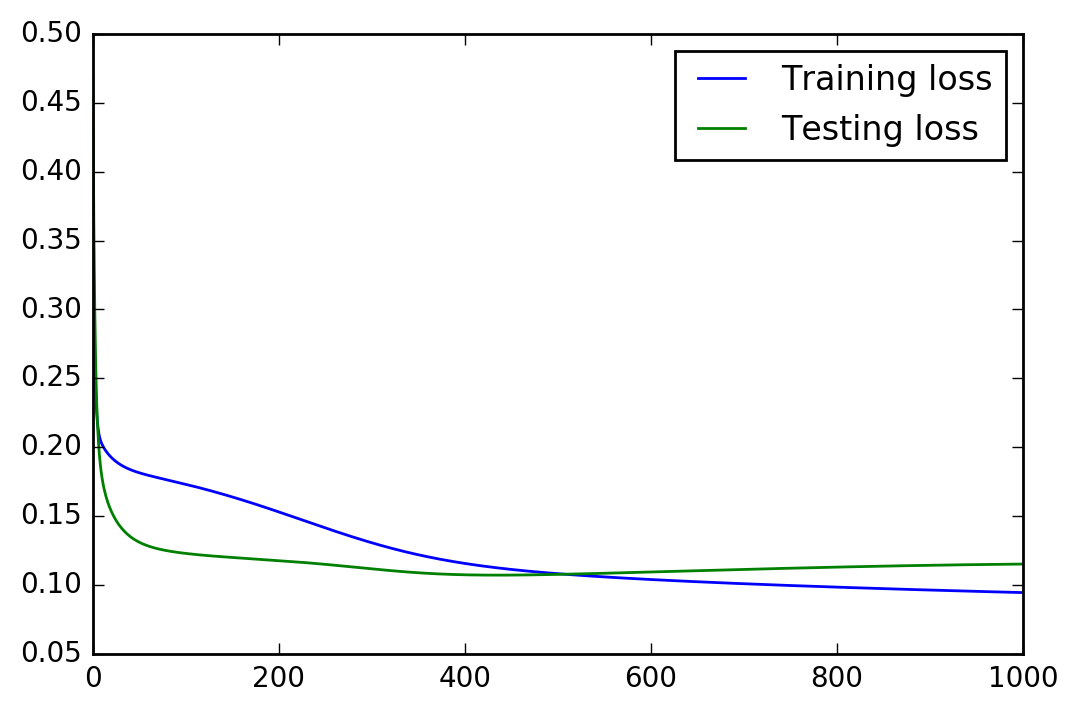

In [263]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['test'], label='Testing loss')
plt.legend()

## Check out your predictions

Here, use the validation data to check that network is accurately making predictions. If your predictions don't match the data, try adjusting the hyperparameters and check to make sure the forward passes in the network are correct.

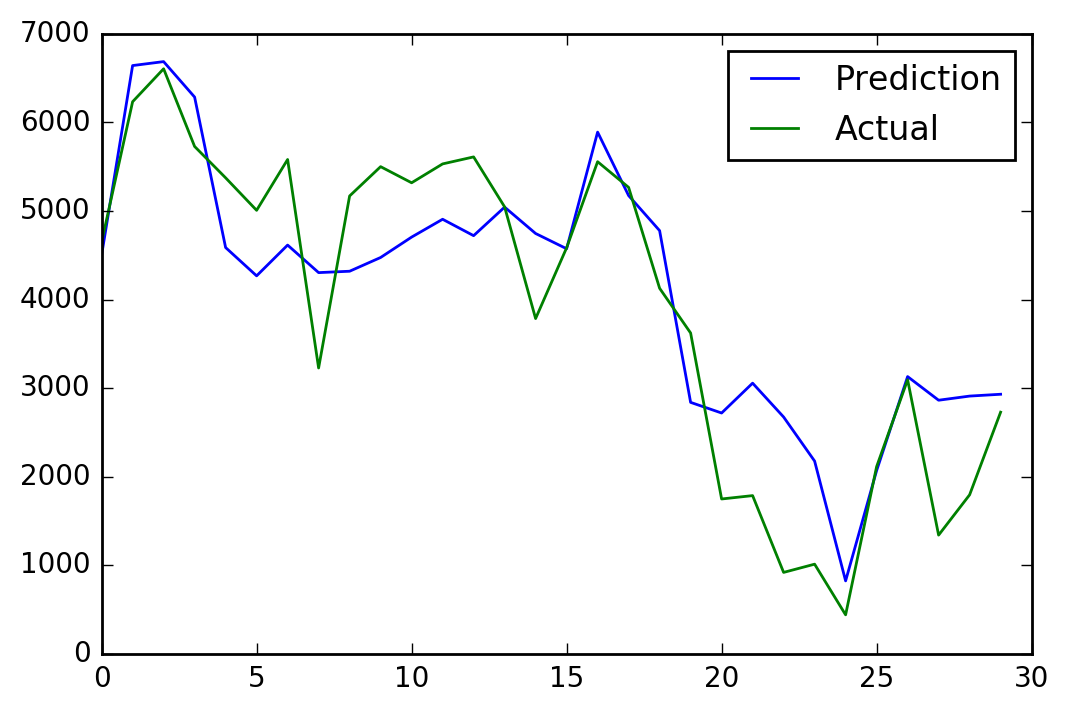

In [265]:
mean, std = scaled_features['cnt']
predictions = network.run(val_features)*std + mean
plt.plot(predictions[0], label='Prediction')
plt.plot((val_targets['cnt']*std + mean).values, label='Data')
plt.legend()